In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


model = torch.hub.load(
    "facebookresearch/dinov2",
    "dinov2_vitb14",
    trust_repo=True
)
model.eval().to(device)

Using cache found in C:\Users\vodka/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\vodka/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\vodka/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\vodka/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affi

In [3]:
import pandas as pd
from pathlib import Path

CSV_PATH = Path("data/labels.csv")
df = pd.read_csv(CSV_PATH)

def normalize_path(p):
    p = p.replace("\\", "/")
    if "/real/" in p:
        return "data/real/" + p.split("/real/")[-1]
    if "/synthetic/" in p:
        return "data/synthetic/" + p.split("/synthetic/")[-1]
    return p

df["path"] = df["path"].apply(normalize_path)

# overwrite safely
df.to_csv("data/labels_fixed.csv", index=False)

print("Saved fixed labels to data/labels_fixed.csv")


Saved fixed labels to data/labels_fixed.csv


In [4]:
df = pd.read_csv("data/labels_fixed.csv")


In [5]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RoomDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img = Image.open(row["path"]).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Failed to load image: {row['path']}") from e

        return self.transform(img), row["room_id"], idx


In [6]:
import numpy as np
from tqdm import tqdm

dataset = RoomDataset(df)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

embeddings = []
room_ids = []

with torch.no_grad():
    for imgs, rids, _ in tqdm(loader):
        imgs = imgs.to(device)
        emb = model(imgs)
        emb = torch.nn.functional.normalize(emb, dim=1)
        embeddings.append(emb.cpu().numpy())
        room_ids.extend(rids.numpy())

embeddings = np.vstack(embeddings)
room_ids = np.array(room_ids)

print("Embeddings shape:", embeddings.shape)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.51s/it]

Embeddings shape: (473, 768)


In [7]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(
    n_neighbors=11,  # include self
    metric="cosine"
)
nn.fit(embeddings)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",11
,"radius radius: float, default=1.0Range of parameter space to use by default for :meth:`radius_neighbors`queries.",1.0
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"p p: float (positive), default=2Parameter for the Minkowski metric fromsklearn.metrics.pairwise.pairwise_distances. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [8]:
def recall_at_k(embeddings, room_ids, k=10):
    nn = NearestNeighbors(n_neighbors=k+1, metric="cosine")
    nn.fit(embeddings)
    neighbors = nn.kneighbors(embeddings, return_distance=False)

    correct = 0
    for i, nbrs in enumerate(neighbors):
        nbrs = nbrs[1:]  # remove self
        if any(room_ids[j] == room_ids[i] for j in nbrs):
            correct += 1

    return correct / len(room_ids)


In [9]:
for k in [1, 5, 10]:
    print(f"Recall@{k}: {recall_at_k(embeddings, room_ids, k):.4f}")


Recall@1: 0.9197
Recall@5: 0.9662
Recall@10: 0.9789


In [10]:
def strict_recall_at_k(embeddings, room_ids, k=10):
    from sklearn.neighbors import NearestNeighbors
    import numpy as np

    nn_model = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(embeddings)
    correct_count = 0

    for i, room_id in enumerate(room_ids):
        _, idxs = nn_model.kneighbors([embeddings[i]])
        idxs = idxs[0][1:]  # skip query itself
        if all(room_ids[j] == room_id for j in idxs):
            correct_count += 1

    return correct_count / len(room_ids)


In [11]:
strict_recalls = {}

for k in range(1, 11):  # k = 1 to 10
    strict_recalls[k] = strict_recall_at_k(embeddings, room_ids, k=k)
    print(f"Strict Recall@{k} (all top-{k} same room): {strict_recalls[k]:.4f}")

Strict Recall@1 (all top-1 same room): 0.9197
Strict Recall@2 (all top-2 same room): 0.8161
Strict Recall@3 (all top-3 same room): 0.7273
Strict Recall@4 (all top-4 same room): 0.6512
Strict Recall@5 (all top-5 same room): 0.5793
Strict Recall@6 (all top-6 same room): 0.5137
Strict Recall@7 (all top-7 same room): 0.4228
Strict Recall@8 (all top-8 same room): 0.3573
Strict Recall@9 (all top-9 same room): 0.2939
Strict Recall@10 (all top-10 same room): 0.1818


    k  strict_recall
0   1       0.919662
1   2       0.816068
2   3       0.727273
3   4       0.651163
4   5       0.579281
5   6       0.513742
6   7       0.422833
7   8       0.357294
8   9       0.293869
9  10       0.181818


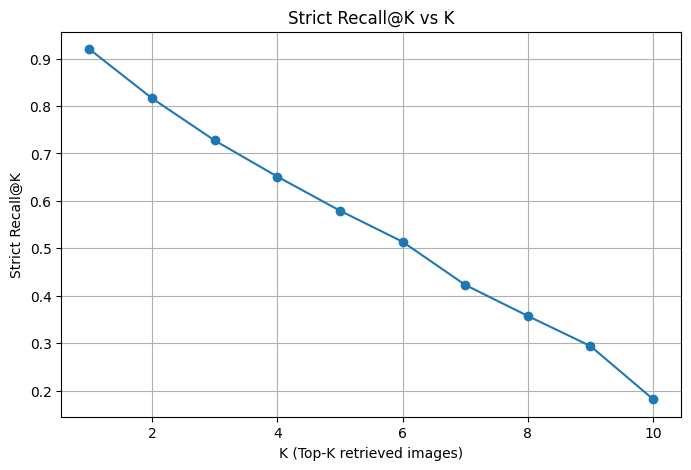

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert dictionary to DataFrame
df_recall = pd.DataFrame({
    "k": list(strict_recalls.keys()),
    "strict_recall": list(strict_recalls.values())
})

# Quick view
print(df_recall)

# Plot Strict Recall@K
plt.figure(figsize=(8,5))
plt.plot(df_recall["k"], df_recall["strict_recall"], marker="o")
plt.xlabel("K (Top-K retrieved images)")
plt.ylabel("Strict Recall@K")
plt.title("Strict Recall@K vs K")
plt.grid(True)
plt.show()


Query index: 407, Room ID: 48


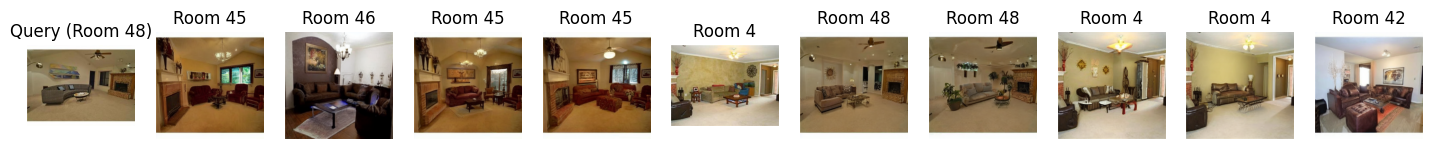

In [17]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def show_random_top_k(embeddings, df, room_ids, k=10):
    """
    Randomly selects a query image and shows top-K neighbors.
    Displays the query's room number.
    """
    # Randomly select a query index
    query_idx = random.randint(0, len(df) - 1)
    query_room = room_ids[query_idx]
    print(f"Query index: {query_idx}, Room ID: {query_room}")

    # Get neighbors
    _, idxs = nn.kneighbors([embeddings[query_idx]], n_neighbors=k+1)
    idxs = idxs[0][1:]  # skip query itself

    # Plot query + top-K
    fig, axes = plt.subplots(1, k+1, figsize=(18,4))
    axes[0].imshow(Image.open(df.iloc[query_idx]["path"]))
    axes[0].set_title(f"Query (Room {query_room})")

    for i, idx in enumerate(idxs):
        axes[i+1].imshow(Image.open(df.iloc[idx]["path"]))
        axes[i+1].set_title(f"Room {room_ids[idx]}")
    
    for ax in axes:
        ax.axis("off")
    plt.show()

# Example usage:
show_random_top_k(embeddings, df, room_ids, k=10)
